<a href="https://colab.research.google.com/github/kartikgill/The-GAN-Book/blob/main/Skill-07/LS-GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Useful Libararies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.1


# Download and Show Data

Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


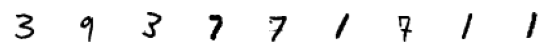

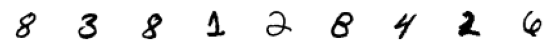

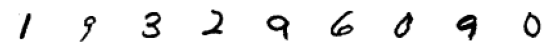

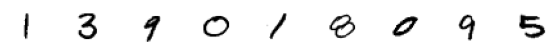

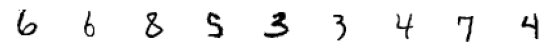

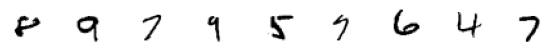

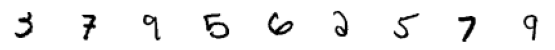

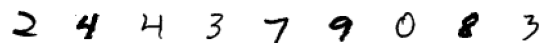

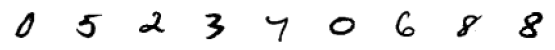

In [3]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))


for k in range(9):
    plt.figure(figsize=(10, 7))
    for j in range(9):
        i = np.random.randint(0, 10000)
        plt.subplot(990 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        #plt.title(trainY[i])
        plt.axis('off')
    plt.show()

In [4]:
#Ten classes
set(trainY)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

# Data Normalization

In [5]:
trainX = [(image-127.5)/127.5 for image in trainX]
testX = [(image-127.5)/127.5 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


# Define Generator Model

In [6]:
random_input = tensorflow.keras.layers.Input(shape = 100)

x = tensorflow.keras.layers.Dense(256)(random_input)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Dense(512)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Dense(1024)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Dense(28*28*1, activation='tanh')(x)
generated_image = tensorflow.keras.layers.Reshape((28, 28, 1))(x)

generator_network = tensorflow.keras.models.Model(inputs=random_input, outputs=generated_image)
generator_network.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048  

# Define  Discriminator

In [7]:
image_input = tensorflow.keras.layers.Input(shape=(28, 28, 1))

x = tensorflow.keras.layers.Flatten()(image_input)

x = tensorflow.keras.layers.Dense(512)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)

x = tensorflow.keras.layers.Dense(256)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)

#Linear activation
d_out = tensorflow.keras.layers.Dense(1)(x)

discriminator_network = tensorflow.keras.models.Model(inputs=image_input, outputs=d_out)

print (discriminator_network.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257 

# Compiling Discriminator

In [8]:
adam_optimizer = tensorflow.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator_network.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])

# Define Least Squares GAN (LS-GAN)

In [9]:
discriminator_network.trainable=False

g_output = generator_network(random_input)

d_output = discriminator_network(g_output)

ls_gan_model = tensorflow.keras.models.Model(inputs = random_input, outputs = d_output)
ls_gan_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model (Functional)           (None, 28, 28, 1)         1493520   
_________________________________________________________________
model_1 (Functional)         (None, 1)                 533505    
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


# Compiling LS-GAN

In [10]:
ls_gan_model.compile(loss='mse', optimizer=adam_optimizer)

# Define Data Generators

In [11]:
indices = [i for i in range(0, len(trainX))]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batches = np.reshape(random_values, (batch_size, noise_size))
    return random_noise_batches

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batches = get_random_noise(batch_size, noise_size) 
    fake_samples = generator_network.predict_on_batch(random_noise_batches)
    return fake_samples

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = trainX[np.array(random_indices),:]
    return real_images

def show_generator_results(generator_network):
    for k in range(9):
        plt.figure(figsize=(10, 7))
        random_noise_batches = get_random_noise(10, noise_size) 
        fake_samples = generator_network.predict_on_batch(random_noise_batches)
        for j in range(9):
            i = j
            plt.subplot(990 + 1 + j)
            plt.imshow(((fake_samples[i,:,:,-1])/2.0)+0.5, cmap='gray_r')
            plt.axis('off')
        plt.show()
    return

# Training LS-GAN

In [ ]:
epochs = 500
batch_size = 100
steps = 500
noise_size = 100

for i in range(0, epochs):
    if (i%1 == 0):
        op = show_generator_results(generator_network)
        #print (op)
    for j in range(steps):
        fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size)
        real_samples = get_real_samples(batch_size=batch_size//2)

        fake_y = np.zeros((batch_size//2, 1))
        real_y = np.ones((batch_size//2, 1))

        # Updating Critic weights

        discriminator_network.trainable=True
        loss_d_real = discriminator_network.train_on_batch(real_samples, real_y)
        loss_d_fake = discriminator_network.train_on_batch(fake_samples, fake_y)

        loss_d = np.add(loss_d_real, loss_d_fake)/2.0

        noise_batches = get_random_noise(batch_size, noise_size)
        
        ls_gan_input = noise_batches
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        ls_gan_output = np.ones((batch_size, 1))
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g = ls_gan_model.train_on_batch(ls_gan_input, ls_gan_output)
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%\
                   (i,j,loss_d[0],loss_d[1]*100,loss_g))

# Results

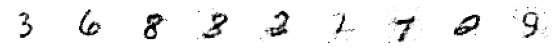

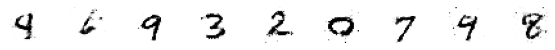

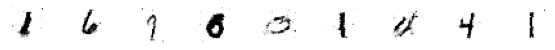

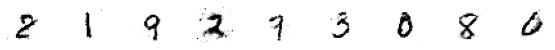

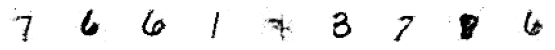

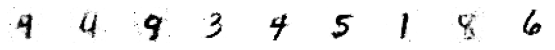

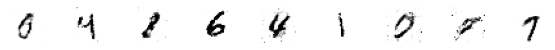

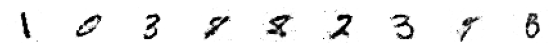

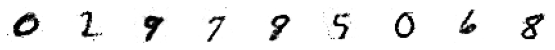

----------------------------------------------------------------------------------------------------


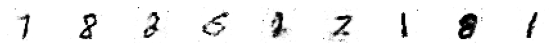

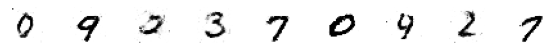

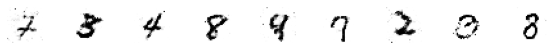

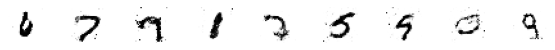

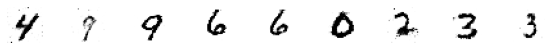

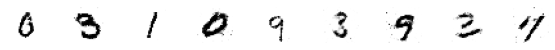

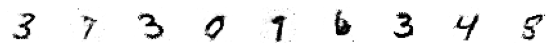

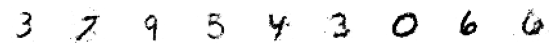

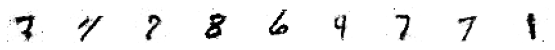

----------------------------------------------------------------------------------------------------


In [13]:
for i in range(2):
    show_generator_results(generator_network)
    print("-"*100)